# Overview

This analysis compares Airbnb listings in Seattle and Boston to determine whether there are any pricing trends that can be uncovered from the listing information.

Key Questions:
1. How do prices compare between Boston and Seattle? How does pricing look across neighborhoods?
2. How are other attributes of the listing related to pricing and availability?
3. Are the factors related to price and availability different in Boston and Seattle?

# Setup

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
# Allow all columns to be displayed
pd.set_option("display.max_columns", None)
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Define functions

In [2]:
'''
    INPUT:
    x - string variable for cleaning
    
    OUTPUT:
    x - variable converted to float with dollar sign and comma stripped out
'''
def clean_money_cols(x):
    x = x.str.replace('$', '', regex=True)
    x = x.str.replace(',', '', regex=True)
    return x.astype(float)


In [3]:
'''
    INPUT:
    date_in - string date for shifting
    x - months to add/subtract
    
    OUTPUT:
    string value of date shifted by x months
'''
def month_shift(date_in, x):    
    return str((pd.to_datetime(date_in) + DateOffset(months=x)).date())

In [4]:
'''
    INPUT:
    df - dataframe with columns to be one hot encoded
    features - list of categorical variables to be one hot encoded
    
    OUTPUT:
    original dataframe with new features added
'''
def append_flg_vars(df, features):
    dummy_vars = pd.get_dummies(full_listing_data[features], prefix=features)
    df = pd.concat([df, dummy_vars], axis=1)
    return df

In [5]:
'''
    INPUT:
    df - dataframe 
    features - list of string columns with lengths to be measured
    
    OUTPUT:
    original dataframe with additional columns measuring lengths of input features list
'''
def append_str_lths(df, features):
    for feat in features:
        new_var_nm = feat + '_lth'
        df[new_var_nm] = df[feat].str.len()
    return df

# Data Understanding

### Read in datasets

In [6]:
# Master dataframes of listings
seattle_listings_df = pd.read_csv('InputData/Seattle/listings.csv')
boston_listings_df = pd.read_csv('InputData/Boston/listings.csv')

In [7]:
# Calendar of listing prices
seattle_cal_df = pd.read_csv('InputData/Seattle/calendar.csv')
boston_cal_df = pd.read_csv('InputData/Boston/calendar.csv')

### Examine datasets

The listing datasets contain overviews of Airbnb listings in Seattle and Boston. The dataframe contains 1 record per scraped listing with various pieces of information about the listing, including freeform text fields, continuous fields, and categorical fields. 

In [8]:
seattle_listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [9]:
boston_listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

The calendar datasets contain multiple records per listing, with pricing info for the listing on different dates.

In [10]:
seattle_cal_df.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


In [11]:
boston_cal_df.head(3)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN


# Data Preparation

In [12]:
# Drop columns that will not be used in analysis
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude']
seattle_listings_df.drop(columns=drop_cols, inplace=True)
boston_listings_df.drop(columns=drop_cols, inplace=True)

In [13]:
# The access column is not in the Boston dataset
boston_listings_df.drop(columns='access', inplace=True)

In [14]:
# Append listings data together
boston_listings_df['city']='Boston'
seattle_listings_df['city']='Seattle'
full_listing_data = pd.concat(objs=[boston_listings_df, seattle_listings_df], axis=0)
full_listing_data.shape

(7403, 77)

In [15]:
full_listing_data.describe()

,id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,7.403000e+03,7401.000000,7401.000000,7403.000000,7373.000000,7387.000000,7393.000000,153.000000,7403.000000,7403.000000,7.403000e+03,7403.000000,7403.000000,7403.000000,7403.000000,7403.000000,5943.000000,5922.000000,5932.000000,5925.000000,5934.000000,5926.000000,5926.000000,0.0,7403.000000,6020.000000
mean,6.950001e+06,32.222537,32.222537,3.200189,1.241150,1.282659,1.674286,856.026144,1.555045,2.757666,1.431337e+04,12.846143,29.559773,48.627583,213.089153,20.684047,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,NaN,7.686073,2.028161
std,4.052397e+06,123.585161,123.585161,1.890166,0.549408,0.823251,1.081355,647.189653,1.200756,13.243828,1.162232e+06,12.069956,23.839400,35.013315,138.342837,36.733024,8.207451,0.821783,0.999271,0.682247,0.656589,0.775312,0.892824,NaN,21.465871,1.968696
min,3.335000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.010000
25%,3.864100e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,9.550000e+01,0.000000,1.000000,7.000000,77.000000,1.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.590000
50%,7.035240e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,770.000000,1.000000,2.000000,1.125000e+03,10.000000,31.000000,56.000000,259.000000,7.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,1.370000
75%,9.500804e+06,4.000000,4.000000,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,3.000000,1.125000e+03,26.000000,55.000000,84.000000,347.000000,23.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,2.890000
max,1.493346e+07,749.000000,749.000000,16.000000,8.000000,7.000000,16.000000,3000.000000,15.000000,1000.000000,1.000000e+08,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000,19.150000


In [16]:
# Add columns to the calendar data to identify the city and append them together
boston_cal_df['city']='Boston'
seattle_cal_df['city']='Seattle'
full_cal_data = pd.concat(objs=[boston_cal_df, seattle_cal_df], axis=0)
full_cal_data.shape

(2702460, 5)

The Boston pricing data goes from September 2016 to September 2017 and the Seattle data goes from January 2016 to January 2017. Price change analysis will need to account for the difference in time horizons.

In [17]:
boston_cal_min, boston_cal_max, seattle_cal_min, seattle_cal_max = boston_cal_df.date.min(), boston_cal_df.date.max(), seattle_cal_df.date.min(), seattle_cal_df.date.max()
print(boston_cal_min, boston_cal_max, seattle_cal_min, seattle_cal_max)

2016-09-06 2017-09-05 2016-01-04 2017-01-02


The price columns all need the same cleaning: stripping out of extra characters and conversion to float.

In [18]:
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

In [19]:
# Clean price columns
full_listing_data[price_cols] = full_listing_data[price_cols].apply(clean_money_cols)

In [20]:
# Clean values in neighborhood and state fields
full_listing_data['neighbourhood'] = full_listing_data['neighbourhood'].fillna(full_listing_data['neighbourhood_cleansed'])
full_listing_data['state']=(full_listing_data['state']).str.upper()

### Missing Values

Records for listings that are currently rented do not have a price listed, so will be dropped from analysis. 

In [21]:
# 100% of rented listings have a missing price
print(full_cal_data.loc[full_cal_data.available=='f']['price'].isna().mean())

1.0


In [22]:
# Drop records with missing price
full_cal_data=full_cal_data.loc[full_cal_data.available=='t']

In [23]:
full_cal_data[['price']]=full_cal_data[['price']].apply(clean_money_cols)
full_cal_data.head()

,listing_id,date,available,price,city
365,3075044,2017-08-22,t,65.0,Boston
366,3075044,2017-08-21,t,65.0,Boston
367,3075044,2017-08-20,t,65.0,Boston
368,3075044,2017-08-19,t,75.0,Boston
369,3075044,2017-08-18,t,75.0,Boston


Some columns in the listing data have a large % of missing data and will not be useful in analysis.

In [24]:
# Some columns in the listing data have a large % of missing data
col_null_val_cts = pd.DataFrame(full_listing_data.isnull().mean(), columns=['count'])
col_null_val_cts.sort_values(by='count', ascending = False, inplace=True)
col_null_val_cts.head()

,count
license,1.000000
square_feet,0.979333
interaction,0.725652
house_rules,0.676753
monthly_price,0.675132


Columns with more than 50% of the data missing were dropped from analysis. 

In [25]:
most_missing_cols = list(full_listing_data.columns[full_listing_data.isnull().mean() > 0.5])
most_missing_cols

['interaction',
 'house_rules',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'license']

In [26]:
full_listing_data.drop(columns=most_missing_cols, inplace=True)

### Generate Additional Features

Does being more or less verbose impact a listing? Measuring the length of free text fields will allow further exploration.

In [27]:
# Features for length measurement
lth_features = ['summary', 'space', 'description', 'neighborhood_overview']

In [28]:
full_listing_data = append_str_lths(full_listing_data, lth_features)

In [76]:
# Measure the sentiment of the listing description
# Handy trick to do so in an easy to use way is found here: https://stackoverflow.com/questions/61608057/output-vader-sentiment-scores-in-columns-based-on-dataframe-rows-of-tweets

In [29]:
analyzer = SentimentIntensityAnalyzer()
full_listing_data['desc_sentiment'] = full_listing_data['description'].apply(analyzer.polarity_scores)
full_listing_data = pd.concat([full_listing_data.drop(['desc_sentiment'], axis=1), full_listing_data['desc_sentiment'].apply(pd.Series)], axis=1)

In [30]:
full_listing_data.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,summary_lth,space_lth,description_lth,neighborhood_overview_lth,neg,neu,pos,compound
0,12147973,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",2015-04-15,"Boston, Massachusetts, United States",NaN,NaN,NaN,f,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,35.0,1,0.0,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,f,moderate,f,f,1,NaN,249.0,481.0,1000,397.0,0.018,0.831,0.151,0.9741
1,3075044,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",2012-06-07,"Boston, Massachusetts, United States",within an hour,100%,100%,f,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",65.0,10.0,0,0.0,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,t,moderate,f,f,1,1.30,247.0,73.0,1000,355.0,0.000,0.880,0.120,0.9670
2,6976,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,2009-05-11,"Boston, Massachusetts, United States",within a few hours,100%,88%,t,Roslindale,1.0,1.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",65.0,NaN,1,20.0,3,45,5 days ago,NaN,19,46,61,319,2016-09-06,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,NaN,f,moderate,t,f,1,0.47,244.0,1000.0,1000,953.0,0.010,0.880,0.110,0.9558
3,1436513,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,2013-04-21,"Boston, Massachusetts, United States",within a few hours,100%,50%,f,NaN,1.0,1.0,"['e

In [31]:
# Features to be one hot encoded
flg_features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'require_guest_profile_picture', 'instant_bookable', 'require_guest_phone_verification']
full_listing_data = append_flg_vars(full_listing_data, flg_features)

# Neighborhood Analysis

Pricing data is very right skewed, so analysis will focus on medians.

In [32]:
full_listing_data = full_listing_data.reset_index()

<AxesSubplot:xlabel='price', ylabel='Count'>

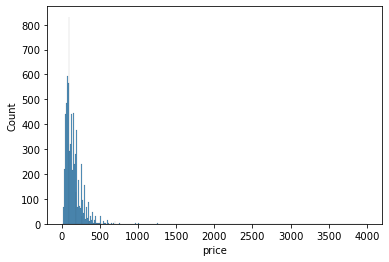

In [33]:
sns.histplot(data=full_listing_data, x='price')

### Boston and Seattle Comparison

In [34]:
city_agg = full_listing_data.groupby('city')['price'].agg(['mean', 'min', 'max', 'median', 'std', 'count']).reset_index()

The confidence intervals for Seattle and Boston do not overlap. 

In [35]:
city_agg['lower_95'] = city_agg['mean']-1.96*city_agg['std']/np.sqrt(city_agg['count'])
city_agg['upper_95'] = city_agg['mean']+1.96*city_agg['std']/np.sqrt(city_agg['count'])
city_agg

,city,mean,min,max,median,std,count,lower_95,upper_95
0,Boston,173.925802,10.0,4000.0,150.0,148.331321,3585,169.070186,178.781418
1,Seattle,127.976166,20.0,1000.0,100.0,90.250022,3818,125.113402,130.838929


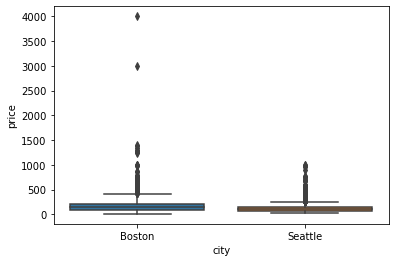

In [36]:
sns.boxplot(data=full_listing_data, x='city', y='price')
plt.savefig('Seattle_Boston_price_boxplot.png')
plt.show()

### Neighbourhood Price Analysis

Explore listing prices in neighborhoods with 30 listings or more. 

In [37]:
price_agg = full_listing_data.groupby(['neighbourhood', 'city'])['price'].agg(['count', 'mean', 'min', 'max', 'std', 'median']).reset_index()
price_agg = price_agg.loc[price_agg['count']>=30].copy()
price_agg.sort_values('median', inplace=True, ascending=False)
price_agg

,neighbourhood,city,count,mean,min,max,std,median
24,Chinatown,Boston,84,233.130952,80.0,399.0,87.310246,219.0
6,Back Bay,Boston,330,243.030303,40.0,1250.0,131.924471,209.0
117,Theater District,Boston,33,234.151515,80.0,600.0,117.446297,209.0
28,Downtown,Boston,33,217.969697,10.0,425.0,104.689566,206.0
124,West End,Boston,74,217.216216,60.0,450.0,81.493301,199.5
37,Fenway/Kenmore,Boston,249,230.104418,30.0,4000.0,282.807621,199.0
22,Charlestown,Boston,98,211.969388,39.0,1000.0,136.958904,195.0
9,Beacon Hill,Boston,210,219.328571,75.0,1345.0,156.509937,188.5
110,South End,Boston,330,204.566667,45.0,1300.0,119.225375,180.0
85,North End,Boston,145,198.289655,35.0,600.0,95.569922,180.0


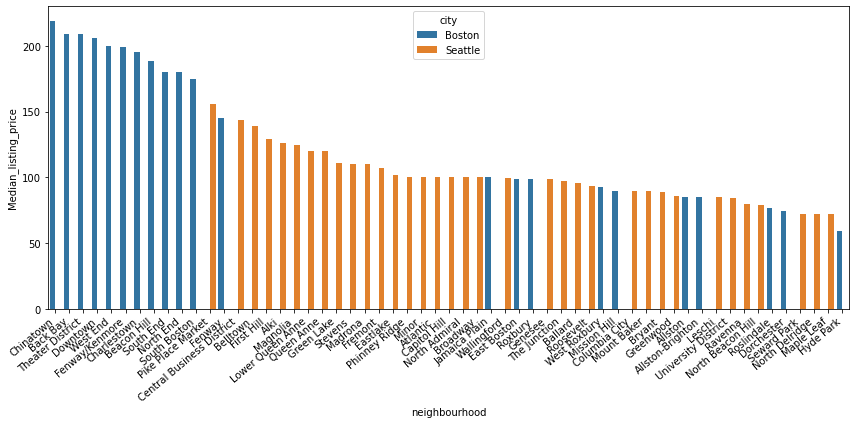

In [38]:
# Create a plot of neighborhood prices
price_agg.rename(columns={'median':'Median_listing_price'}, inplace=True)
plt.figure(figsize=(12,6))
cht = sns.barplot(data=price_agg, x='neighbourhood', y='Median_listing_price', hue='city')
cht.set_xticklabels(cht.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.savefig('Seattle_Boston_City_Airbnb_Neigh_pricing.png')
plt.show()

### Neighborhood Availability Analysis

In [39]:
avail_agg = full_listing_data.groupby(['neighbourhood', 'city'])['availability_365'].agg(['count', 'mean', 'min', 'max', 'std', 'median']).reset_index()
avail_agg = avail_agg.loc[avail_agg['count']>=30].copy()
avail_agg.sort_values('median', inplace=True, ascending=False)
avail_agg

,neighbourhood,city,count,mean,min,max,std,median
68,Magnolia,Seattle,55,279.272727,2,365,119.461051,349.0
118,University District,Seattle,122,273.352459,0,365,118.950224,348.0
15,Broadway,Seattle,49,234.653061,0,365,150.901948,337.0
121,Wallingford,Seattle,164,258.878049,0,365,121.629064,335.0
70,Maple Leaf,Seattle,43,286.534884,0,365,109.342047,335.0
84,North Delridge,Seattle,30,247.266667,0,365,142.451912,334.5
80,North Admiral,Seattle,53,268.943396,0,365,119.357320,333.0
1,Alki,Seattle,40,261.600000,0,365,124.797436,332.5
21,Central Business District,Seattle,95,262.694737,0,365,122.528509,331.0
76,Minor,Seattle,207,258.512077,0,365,121.820968,331.0


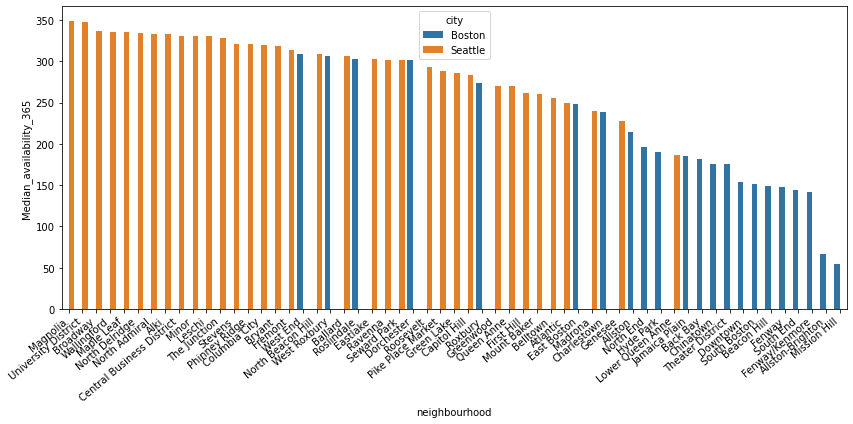

In [40]:
# Create a plot of neighborhood availability
avail_agg.rename(columns={'median':'Median_availability_365'}, inplace=True)
plt.figure(figsize=(12,6))
cht = sns.barplot(data=avail_agg, x='neighbourhood', y='Median_availability_365', hue='city', hue_order=['Boston', 'Seattle'])
cht.set_xticklabels(cht.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.savefig('Seattle_Boston_City_Airbnb_Neigh_avail.png')
plt.show()

# Pricing and Availability Factor Analysis

Set display options so that large tables of data can be viewed in entirety.

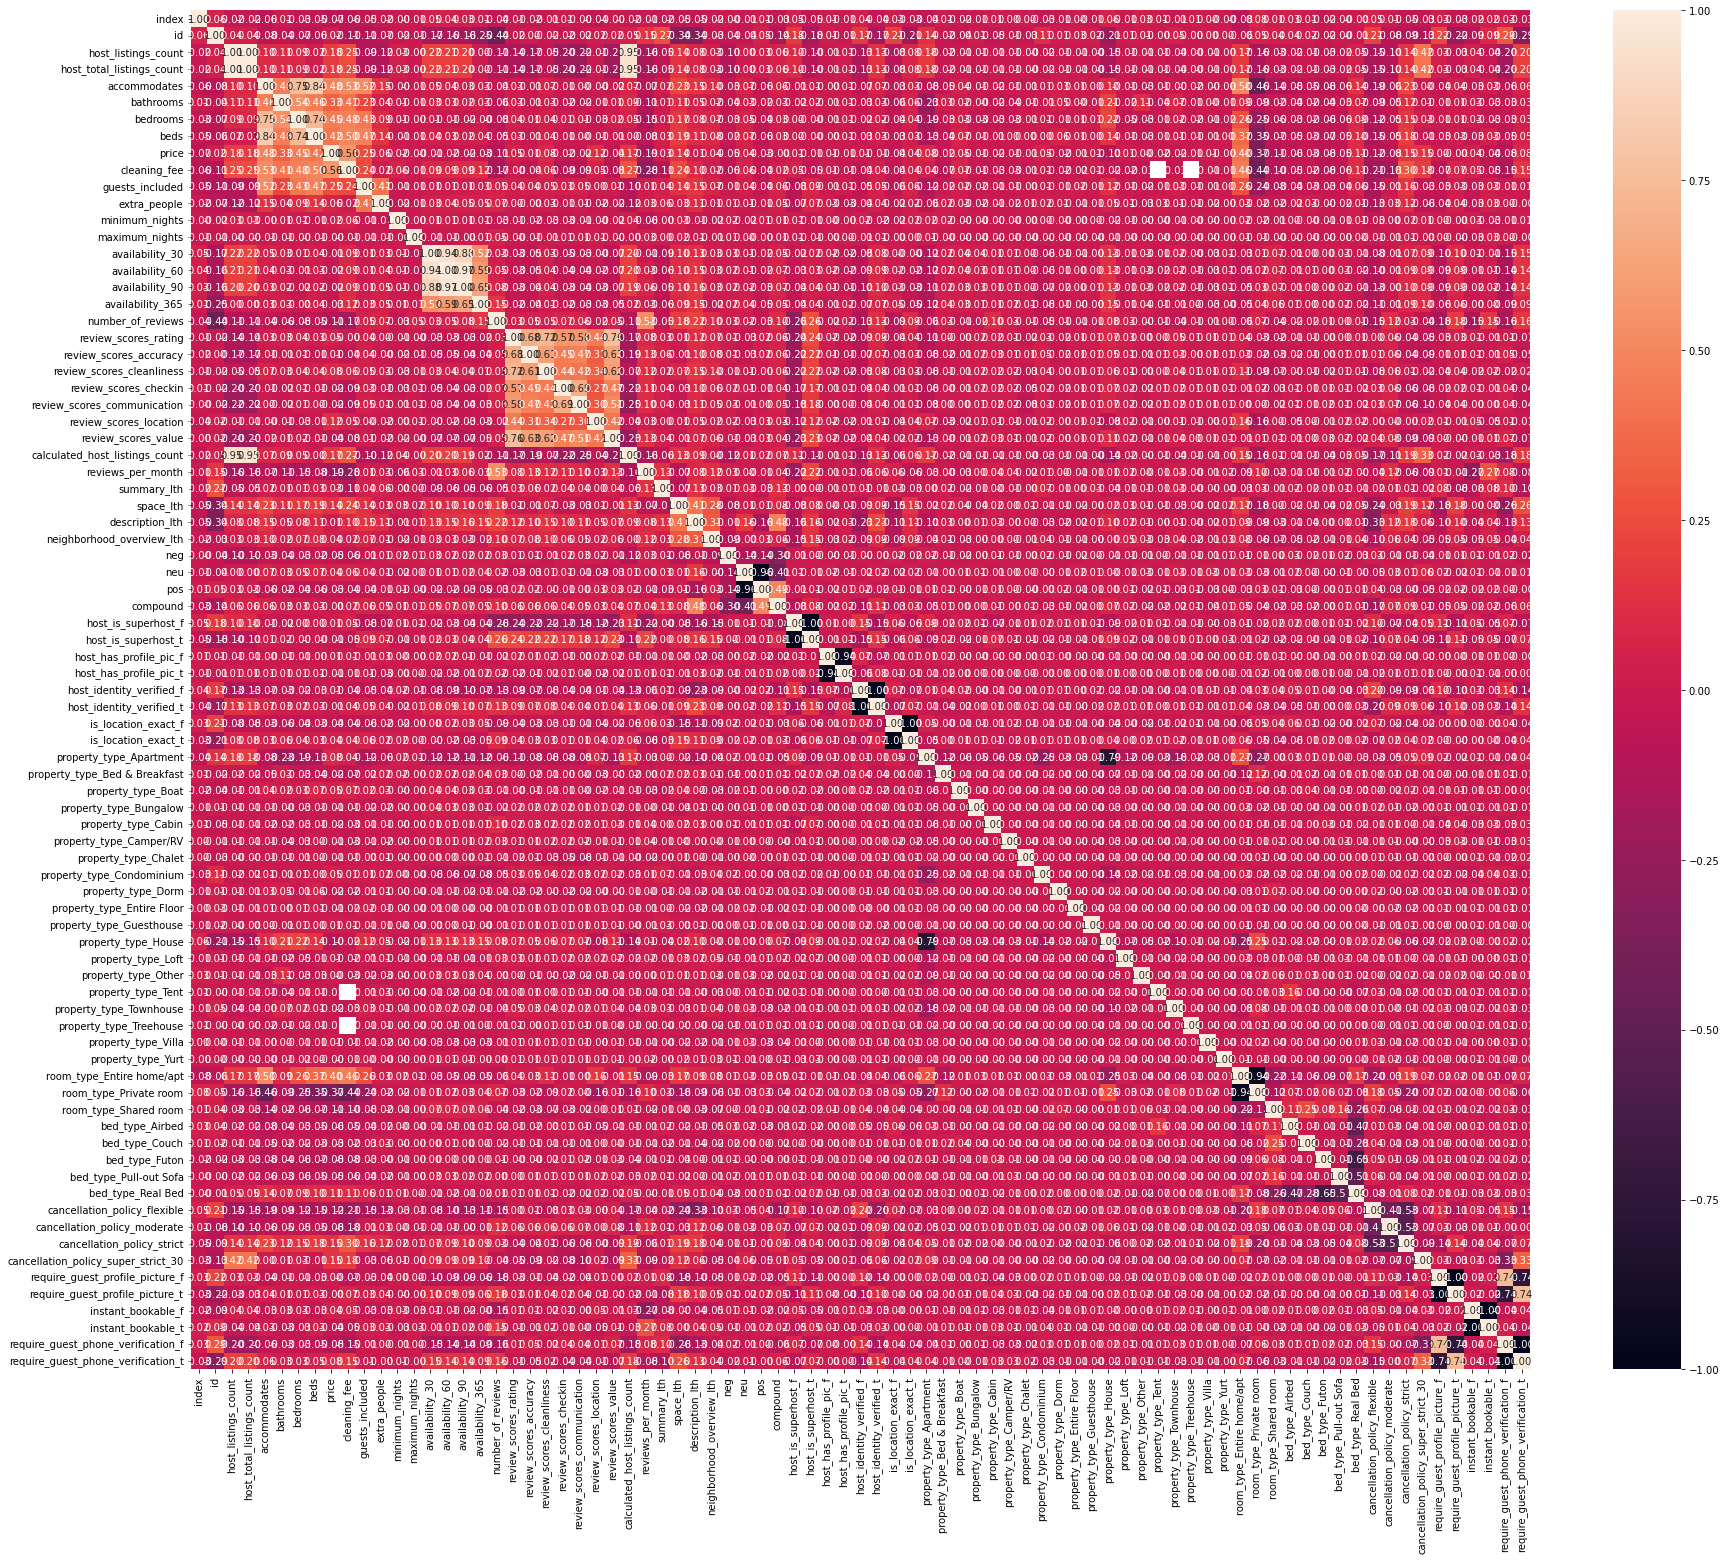

In [41]:
plt.figure(figsize=(30,25))
sns.heatmap(full_listing_data.corr(), annot=True, fmt=".2f");
plt.savefig('Seattle_Boston_Correlations.png')

In [42]:
pd.set_option('display.max_rows', 10)

In [43]:
full_corrs = full_listing_data.corr().reset_index()[['level_0', 'price', 'availability_365']]
full_corrs

,level_0,price,availability_365
0,index,-0.065578,0.012337
1,id,0.015243,-0.254354
2,host_listings_count,0.184821,0.000249
3,host_total_listings_count,0.184821,0.000249
4,accommodates,0.479576,0.030349
...,...,...,...
76,require_guest_profile_picture_t,-0.002607,0.061512
77,instant_bookable_f,0.042674,-0.003830
78,instant_bookable_t,-0.042674,0.003830
79,require_guest_phone_verification_f,-0.083078,-0.089579


In [44]:
# Rename columns
full_corrs.rename(columns={'level_0':'factor', 'price':'price_correlation', 'availability_365':'availability_365_correlation'}, inplace=True)

In [45]:
full_corrs.sort_values('price_correlation')

,factor,price_correlation,availability_365_correlation
64,room_type_Private room,-0.371491,0.035129
27,reviews_per_month,-0.185488,0.029749
71,cancellation_policy_flexible,-0.115466,-0.108696
65,room_type_Shared room,-0.112422,0.057636
18,number_of_reviews,-0.110149,0.148615
...,...,...,...
7,beds,0.422665,0.035620
6,bedrooms,0.451145,-0.004787
4,accommodates,0.479576,0.030349
9,cleaning_fee,0.564452,0.124229


In [46]:
full_corrs.loc[~(full_corrs['factor'].isin(['id', 
                                          'availability_30', 
                                          'availability_60', 
                                          'availability_90',
                                           'availability_365']))].sort_values('availability_365_correlation')

,factor,price_correlation,availability_365_correlation
44,property_type_Apartment,0.080167,-0.120180
71,cancellation_policy_flexible,-0.115466,-0.108696
79,require_guest_phone_verification_f,-0.083078,-0.089579
51,property_type_Condominium,0.049796,-0.076400
40,host_identity_verified_f,0.009593,-0.066852
...,...,...,...
74,cancellation_policy_super_strict_30,0.151142,0.101358
9,cleaning_fee,0.564452,0.124229
30,description_lth,0.012268,0.147068
18,number_of_reviews,-0.110149,0.148615


In [47]:
full_corrs.loc[full_corrs['factor']=='review_scores_rating']

,factor,price_correlation,availability_365_correlation
19,review_scores_rating,0.052656,-0.024883


Iteratively generate scatterplots and boxplots for further examinations of variables in the dataset. Create lists of features of interest for analysis. Categorical and continuous features will be analyzed separately.

### Generate plots for correlations with pricing 

In [48]:
cat_features = ['state', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'bed_type', 
             'instant_bookable', 'require_guest_profile_picture', 
                'require_guest_phone_verification', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
               'cancellation_policy']
cont_features = ['host_listings_count', 'guests_included','bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'number_of_reviews', 
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'summary_lth', 'space_lth', 'description_lth', 'neighborhood_overview_lth', 'neg', 'neu', 'pos']

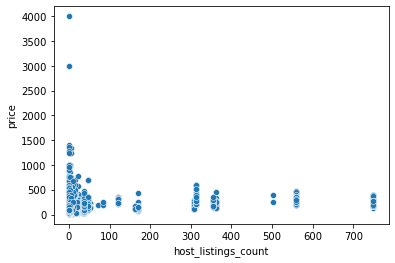

0.18482097536478806


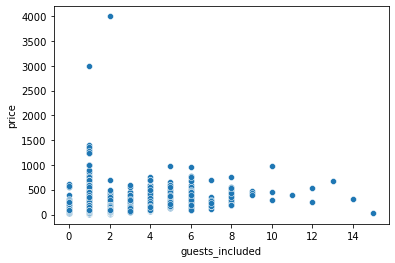

0.25021226556981313


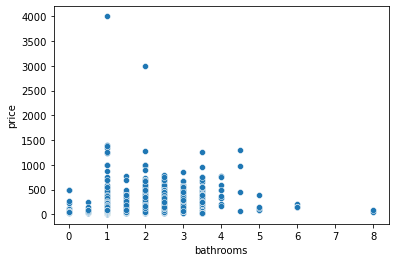

0.33304799214634895


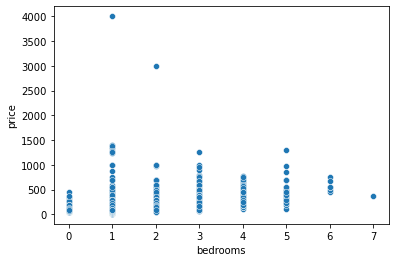

0.4511448499912828


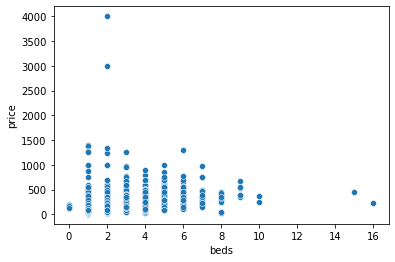

0.4226651066042296


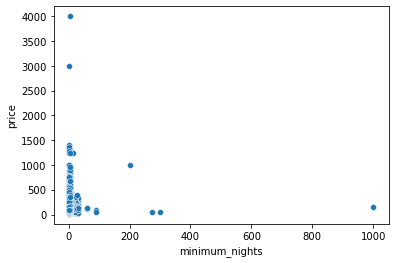

0.021377459837358108


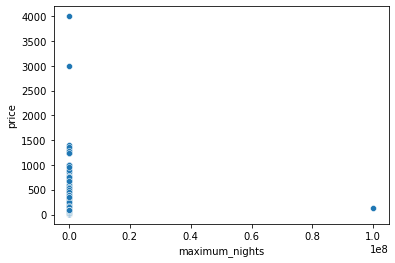

-0.002351639302038285


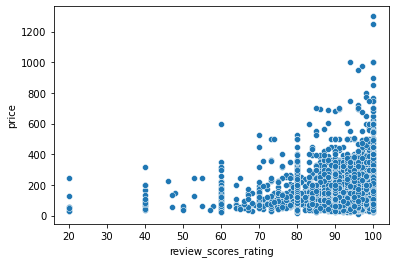

0.05265576381512384


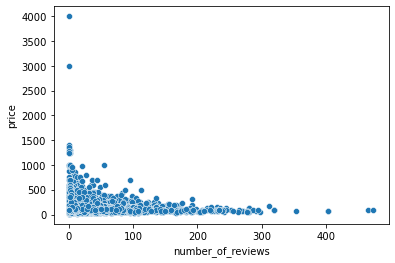

-0.11014889419865842


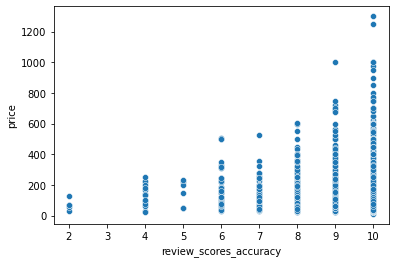

0.007474134746899465


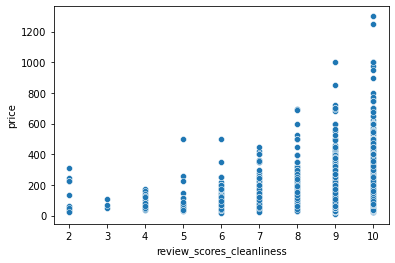

0.07902458035321808


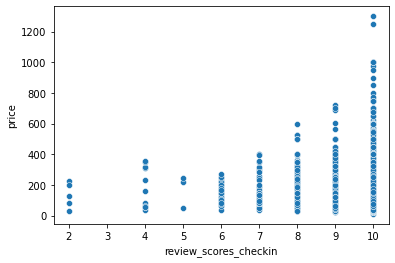

-0.018679040245890434


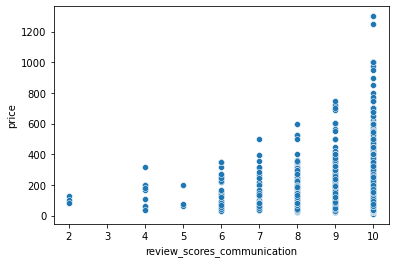

-0.01648644276287894


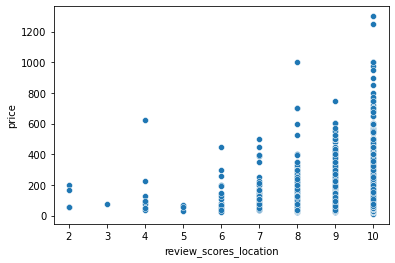

0.11952932298521997


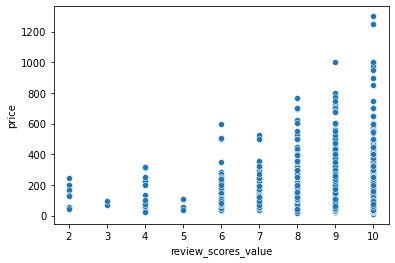

-0.039908511755510655


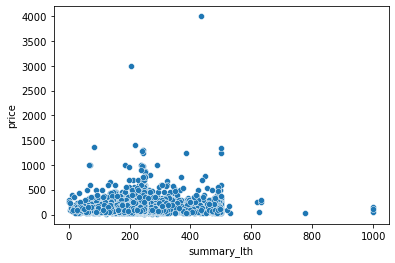

0.031129303047438012


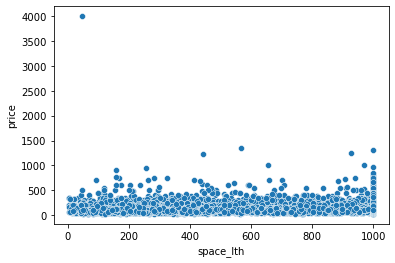

0.13992106840654894


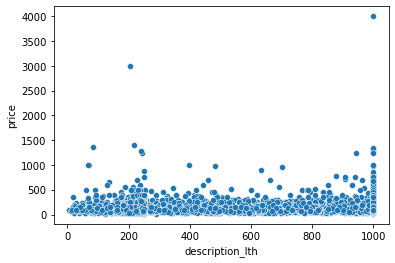

0.012268048799832721


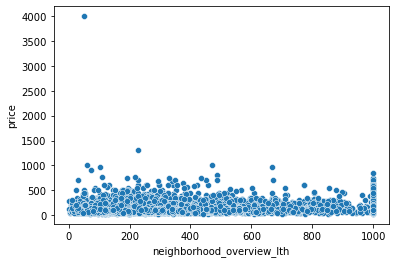

0.04133720160731143


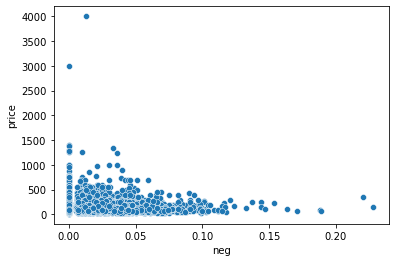

-0.04970819027544575


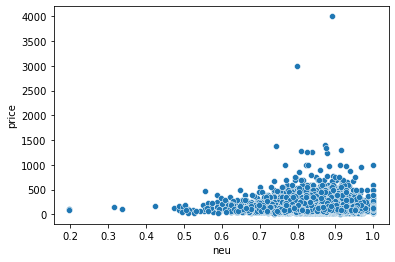

0.04064892793930527


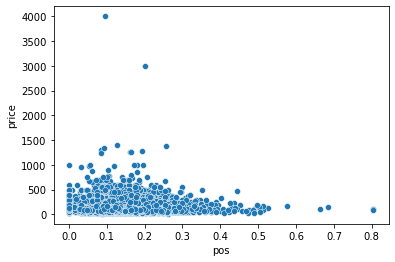

-0.02699074094351139


In [49]:
# Generate scatterplots for continous features
for feat in cont_features:
    sns.scatterplot(data=full_listing_data, x=feat, y='price')
    plt.savefig('Price_scatter_' + feat + '.png')
    plt.show()
    print(full_listing_data[feat].corr(full_listing_data['price']))
    

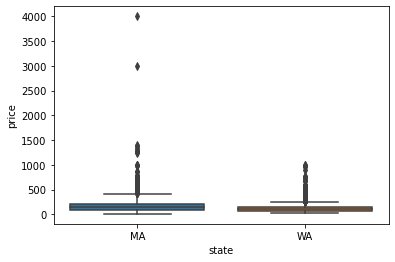

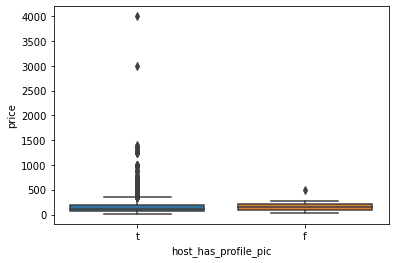

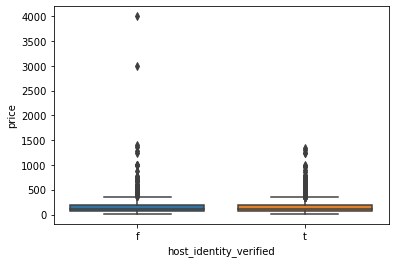

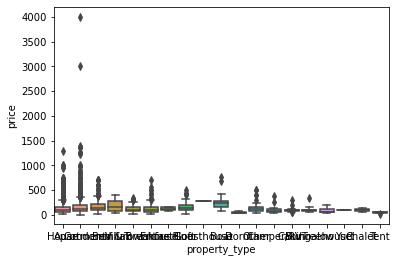

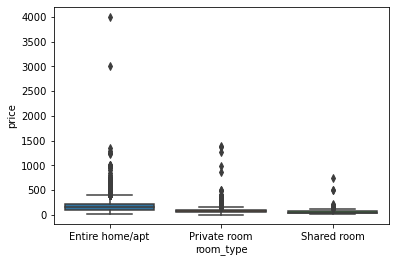

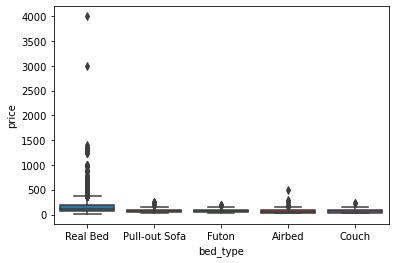

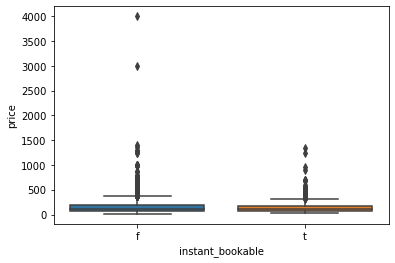

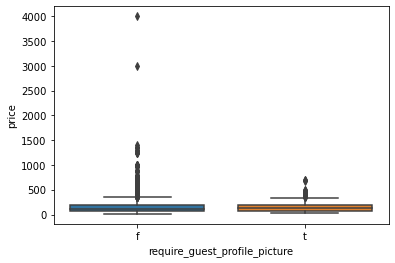

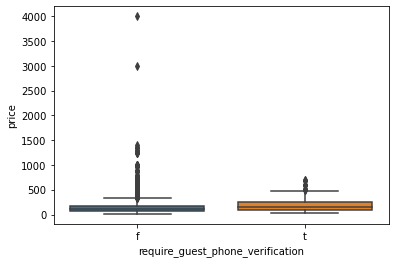

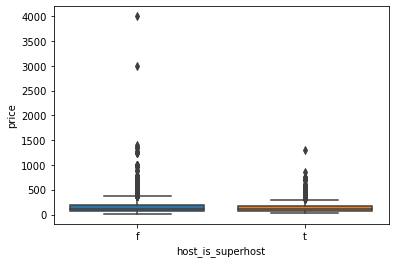

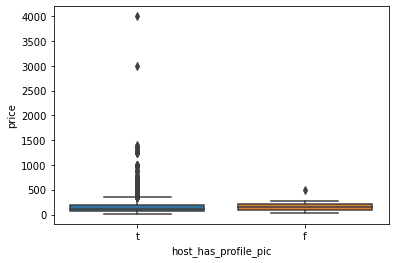

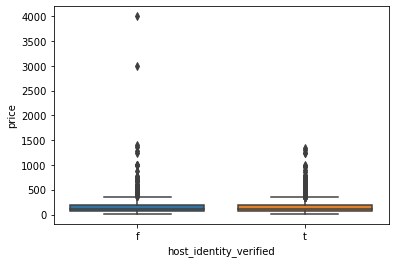

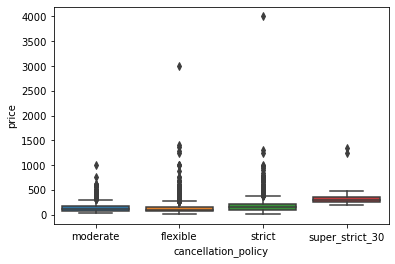

In [50]:
# Generate boxplots for categorical features
for feat in cat_features:
    sns.boxplot(data=full_listing_data, x=feat, y='price')
    plt.savefig('Price_boxplot_' + feat + '.png')
    plt.show()

Property type has too many categories to be seen clearly on a boxplot, but appears to have some interesting trends.

In [51]:
prop_type_price_aggs = full_listing_data.groupby('property_type')['price'].agg(['mean', 'std', 'count']).reset_index().sort_values('mean', ascending=False)
# Only keep property types with 30 or more observations
prop_type_price_aggs = prop_type_price_aggs.loc[prop_type_price_aggs['count']>=30]
# Add calculations to compare intervals using the CLT
prop_type_price_aggs['lower_95'] = prop_type_price_aggs['mean']-1.96*prop_type_price_aggs['std']/np.sqrt(prop_type_price_aggs['count'])
prop_type_price_aggs['upper_95'] = prop_type_price_aggs['mean']+1.96*prop_type_price_aggs['std']/np.sqrt(prop_type_price_aggs['count'])
prop_type_price_aggs

,property_type,mean,std,count,lower_95,upper_95
7,Condominium,179.186335,120.310020,322,166.045289,192.327381
12,Loft,160.240506,95.293906,79,139.226558,181.254454
0,Apartment,158.626389,130.325587,4320,154.740021,162.512757
13,Other,153.641026,119.097149,39,116.262245,191.019807
15,Townhouse,135.604651,104.200300,172,120.032062,151.177240
11,House,132.167320,113.265356,2295,127.533258,136.801382
1,Bed & Breakfast,121.153846,69.157467,78,105.805985,136.501707


### Generate plots for correlations with availability

Generate plots for availability data. Availability is a categorical variable, but since it is ordinal it will be considered continuous for the purpose of this analysis.

<AxesSubplot:xlabel='availability_365', ylabel='Count'>

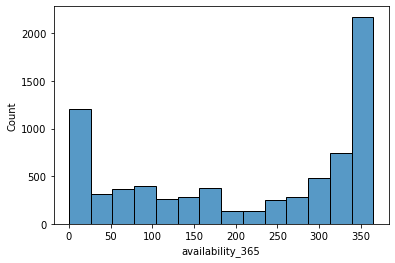

In [52]:
sns.histplot(data=full_listing_data, x='availability_365')

In [53]:
cont_features

['host_listings_count',
 'guests_included',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'review_scores_rating',
 'number_of_reviews',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'summary_lth',
 'space_lth',
 'description_lth',
 'neighborhood_overview_lth',
 'neg',
 'neu',
 'pos']

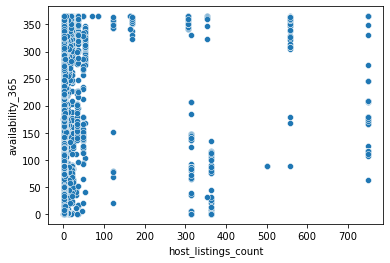

0.0002492767175000479


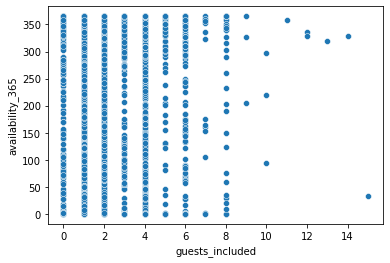

0.02973807959706137


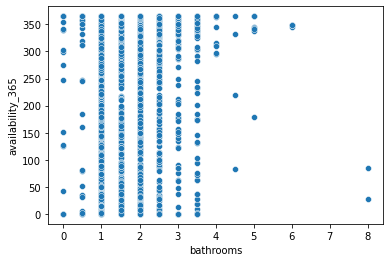

0.03126476534440436


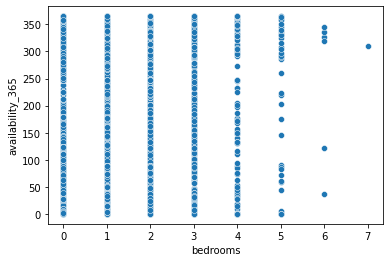

-0.004787213796266975


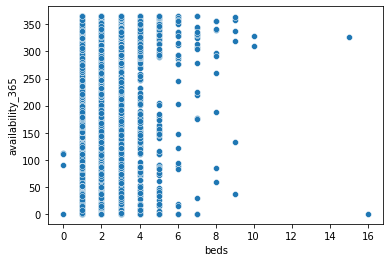

0.03561975341609097


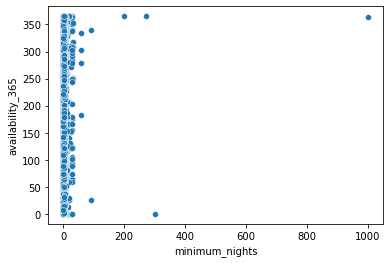

0.005445339720903902


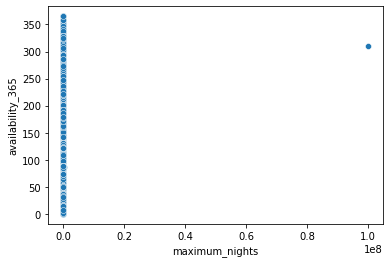

0.008152192093089984


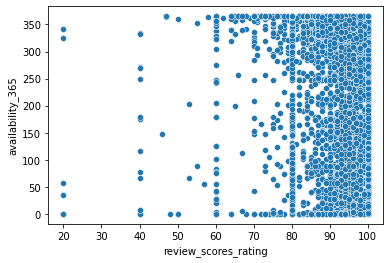

-0.024883401100712365


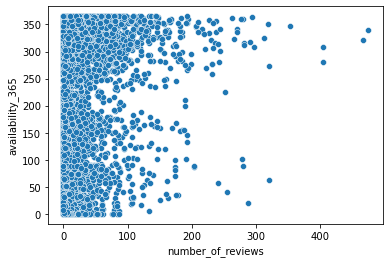

0.14861453809311687


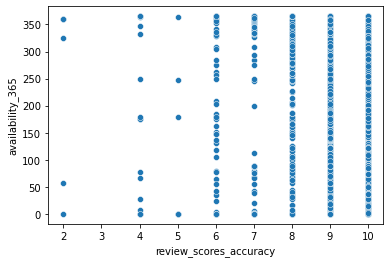

-0.03781490013618584


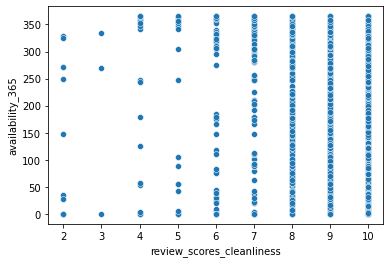

0.01184953021894819


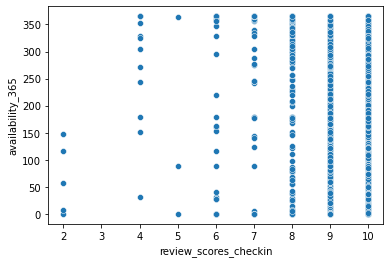

-0.015036765523349229


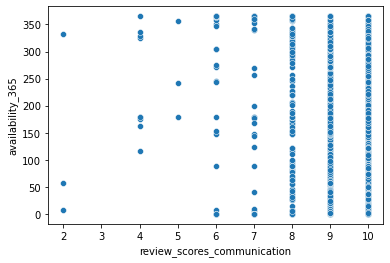

-0.026349983702179714


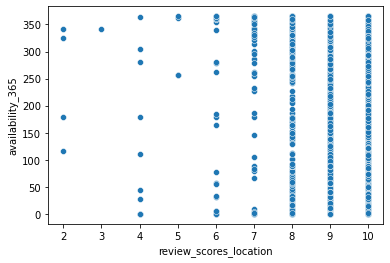

-0.03474193014239131


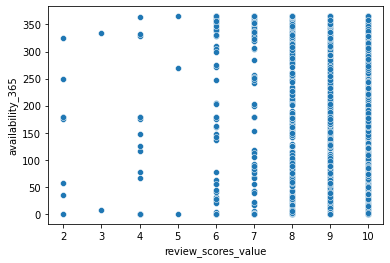

-0.05005437318903781


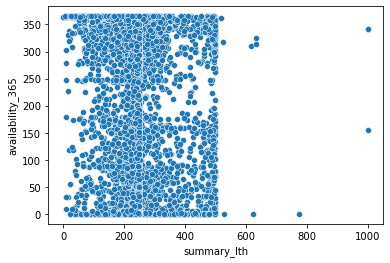

-0.06386626403999622


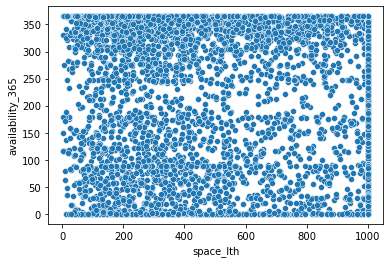

0.08852125214616148


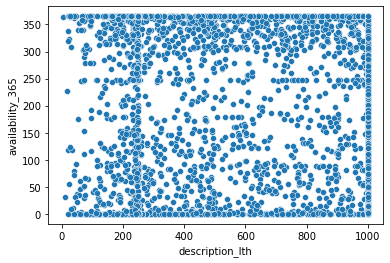

0.1470676101558166


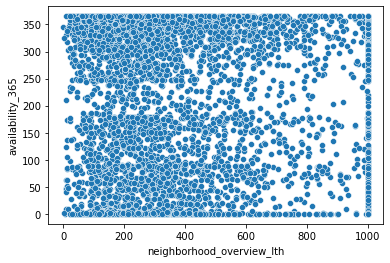

-0.021184900623561147


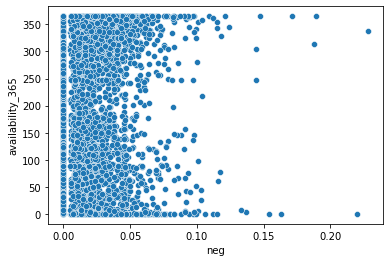

0.021299854655401688


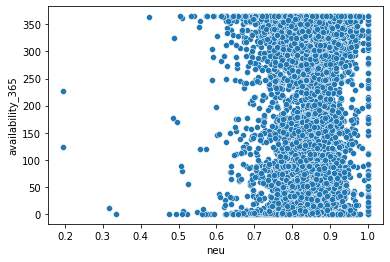

0.04052060978463196


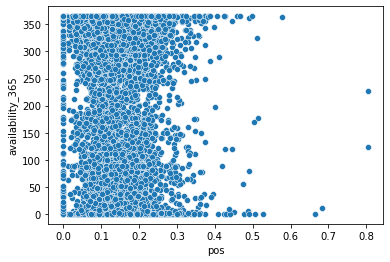

-0.04631062558615333


In [54]:
# Generate scatterplots for continous features
for feat in cont_features:
    sns.scatterplot(data=full_listing_data, x=feat, y='availability_365')
    plt.savefig('Avail_scatter_' + feat + '.png')
    plt.show()
    print(full_listing_data[feat].corr(full_listing_data['availability_365']))

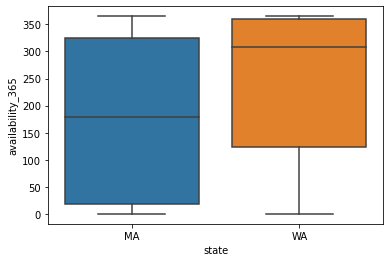

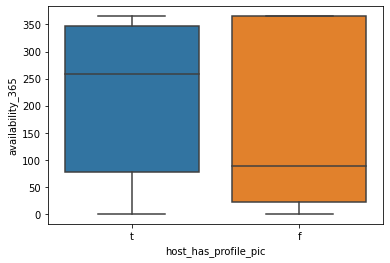

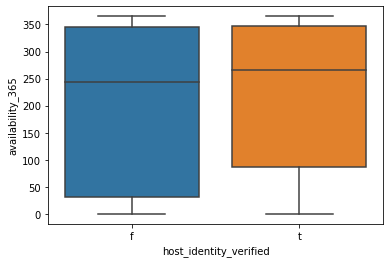

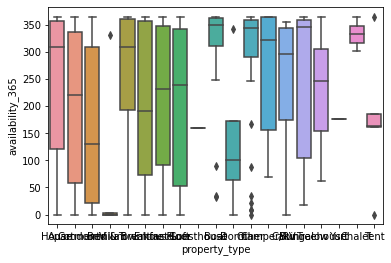

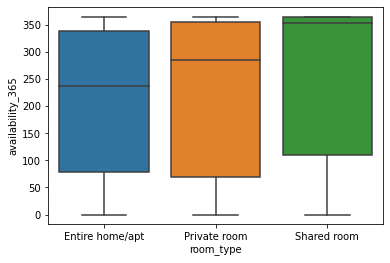

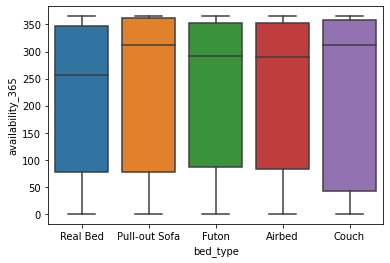

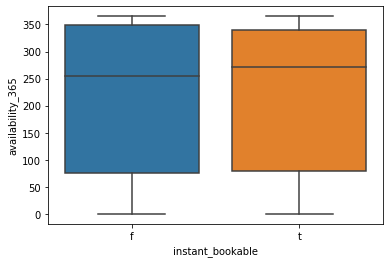

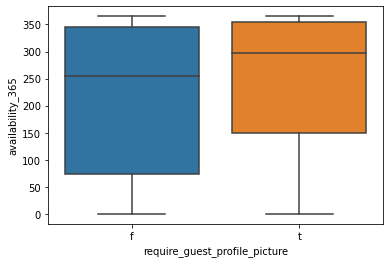

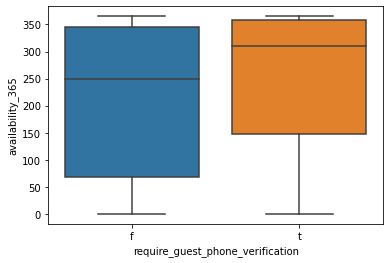

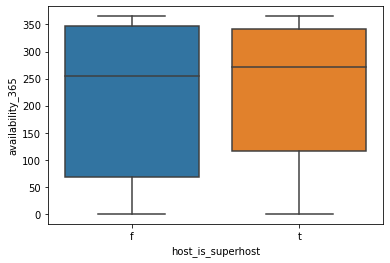

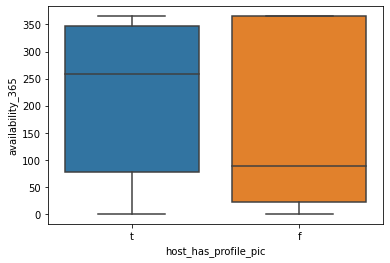

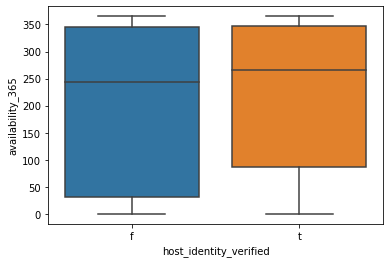

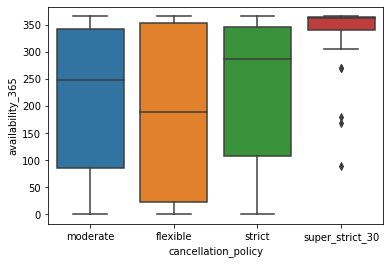

In [55]:
# Generate boxplots for categorical features
for feat in cat_features:
    sns.boxplot(data=full_listing_data, x=feat, y='availability_365')
    plt.savefig('Avail_boxplot_' + feat + '.png')
    plt.show()

In [56]:
prop_type_avail_aggs = full_listing_data.groupby('property_type')['availability_365'].agg(['mean', 'std', 'count']).reset_index().sort_values('mean', ascending=False)
# Only keep property types with 30 or more observations
prop_type_avail_aggs = prop_type_avail_aggs.loc[prop_type_avail_aggs['count']>=30]
# Add calculations to compare intervals using the CLT
prop_type_avail_aggs['lower_95'] = prop_type_avail_aggs['mean']-1.96*prop_type_avail_aggs['std']/np.sqrt(prop_type_avail_aggs['count'])
prop_type_avail_aggs['upper_95'] = prop_type_avail_aggs['mean']+1.96*prop_type_avail_aggs['std']/np.sqrt(prop_type_avail_aggs['count'])
prop_type_avail_aggs

,property_type,mean,std,count,lower_95,upper_95
13,Other,287.205128,119.805803,39,249.603935,324.806321
1,Bed & Breakfast,266.358974,113.966955,78,241.066710,291.651239
11,House,243.823529,129.352653,2295,238.531283,249.115776
15,Townhouse,205.331395,137.367525,172,184.802011,225.860779
0,Apartment,199.044676,139.700515,4320,194.878744,203.210608
12,Loft,193.493671,146.300873,79,161.231808,225.755534
7,Condominium,163.527950,141.652995,322,148.055685,179.000215


# Compare relationships in Seattle and Boston

In [57]:
# Subset correlation matrix to focus on relationships with price and availability
bost_price_avail_cors = full_listing_data[full_listing_data['city']=='Boston'].corr().reset_index()[['level_0', 'price', 'availability_365']]

In [58]:
bost_price_avail_cors.head()

,level_0,price,availability_365
0,index,-0.046316,-0.002401
1,id,-0.059198,-0.208143
2,host_listings_count,0.171930,0.058604
3,host_total_listings_count,0.171930,0.058604
4,accommodates,0.437756,0.056993


In [59]:
# Add absolute value columns
bost_price_avail_cors['bost_price_corr_abs'], bost_price_avail_cors['bost_avail_cor_abs'] = abs(bost_price_avail_cors['price']), abs(bost_price_avail_cors['availability_365'])

In [60]:
bost_price_avail_cors.head()

,level_0,price,availability_365,bost_price_corr_abs,bost_avail_cor_abs
0,index,-0.046316,-0.002401,0.046316,0.002401
1,id,-0.059198,-0.208143,0.059198,0.208143
2,host_listings_count,0.171930,0.058604,0.171930,0.058604
3,host_total_listings_count,0.171930,0.058604,0.171930,0.058604
4,accommodates,0.437756,0.056993,0.437756,0.056993


In [61]:
bost_price_avail_cors.loc[(~bost_price_avail_cors['price'].isna())].sort_values('price')

,level_0,price,availability_365,bost_price_corr_abs,bost_avail_cor_abs
64,room_type_Private room,-0.414956,0.016913,0.414956,0.016913
27,reviews_per_month,-0.157016,0.042458,0.157016,0.042458
79,require_guest_phone_verification_f,-0.134929,-0.126633,0.134929,0.126633
55,property_type_House,-0.123051,0.119529,0.123051,0.119529
71,cancellation_policy_flexible,-0.104841,-0.206135,0.104841,0.206135
...,...,...,...,...,...
6,bedrooms,0.385298,0.028642,0.385298,0.028642
63,room_type_Entire home/apt,0.435788,-0.026211,0.435788,0.026211
4,accommodates,0.437756,0.056993,0.437756,0.056993
9,cleaning_fee,0.490210,0.220611,0.490210,0.220611


In [62]:
# Rename columns for clarity
bost_price_avail_cors.rename(columns={'level_0':'field','price':'bost_price_cor', 'availability_365':'bost_avail_cor'}, inplace=True)

In [63]:
# Examine Seattle correlations

In [64]:
# Subset correlation matrix to focus on relationships with price and availability
seat_price_avail_cors = full_listing_data[full_listing_data['city']=='Seattle'].corr().reset_index()[['level_0', 'price', 'availability_365']]

In [65]:
# Add absolute value columns
seat_price_avail_cors['seat_price_corr_abs'], seat_price_avail_cors['seat_avail_cor_abs'] = abs(seat_price_avail_cors['price']), abs(seat_price_avail_cors['availability_365'])

In [66]:
seat_price_avail_cors.loc[(~seat_price_avail_cors['price'].isna())].sort_values('price')

,level_0,price,availability_365,seat_price_corr_abs,seat_avail_cor_abs
64,room_type_Private room,-0.387502,0.101668,0.387502,0.101668
27,reviews_per_month,-0.218588,0.002312,0.218588,0.002312
65,room_type_Shared room,-0.158473,0.073415,0.158473,0.073415
71,cancellation_policy_flexible,-0.134171,-0.027769,0.134171,0.027769
18,number_of_reviews,-0.124695,0.094273,0.124695,0.094273
...,...,...,...,...,...
7,beds,0.589525,-0.009773,0.589525,0.009773
6,bedrooms,0.627720,-0.049788,0.627720,0.049788
4,accommodates,0.652218,-0.031535,0.652218,0.031535
9,cleaning_fee,0.656938,0.061467,0.656938,0.061467


In [67]:
# Rename columns for clarity
seat_price_avail_cors.rename(columns={'level_0':'field','price':'seat_price_cor', 'availability_365':'seat_avail_cor'}, inplace=True)

In [68]:
# join city data together
full_cor_dataset = pd.merge(bost_price_avail_cors, seat_price_avail_cors, on='field')

In [69]:
# calculate differences in correlation
full_cor_dataset['price_dif']=full_cor_dataset['bost_price_cor']-full_cor_dataset['seat_price_cor']
full_cor_dataset['avail_dif']=full_cor_dataset['bost_avail_cor']-full_cor_dataset['seat_avail_cor']
full_cor_dataset['avail_dif_abs'] = abs(full_cor_dataset['avail_dif'])
full_cor_dataset['price_dif_abs'] = abs(full_cor_dataset['price_dif'])

In [70]:
# Examine largest differences in relationship with price
full_cor_dataset.loc[full_cor_dataset['price_dif_abs']>0].sort_values('price_dif_abs',ascending=False)[['field', 'seat_price_cor', 'bost_price_cor', 'price_dif_abs']]

,field,seat_price_cor,bost_price_cor,price_dif_abs
5,bathrooms,0.516424,0.248234,0.268190
6,bedrooms,0.627720,0.385298,0.242422
7,beds,0.589525,0.370013,0.219512
26,calculated_host_listings_count,-0.054092,0.161855,0.215947
4,accommodates,0.652218,0.437756,0.214462
...,...,...,...,...
41,host_identity_verified_t,0.004857,0.002059,0.002798
12,minimum_nights,0.017297,0.020054,0.002757
13,maximum_nights,-0.003336,-0.005498,0.002162
56,property_type_Loft,0.008807,0.008121,0.000686


In [71]:
full_cor_dataset.loc[(full_cor_dataset['avail_dif_abs']>0) & (full_cor_dataset['field']!='index')].sort_values('avail_dif_abs',ascending=False)[['field', 'seat_avail_cor', 'bost_avail_cor', 'avail_dif_abs']]

,field,seat_avail_cor,bost_avail_cor,avail_dif_abs
71,cancellation_policy_flexible,-0.027769,-0.206135,0.178366
9,cleaning_fee,0.061467,0.220611,0.159143
30,description_lth,0.042212,0.166295,0.124083
10,guests_included,-0.048922,0.071025,0.119948
73,cancellation_policy_strict,0.053725,0.159601,0.105875
...,...,...,...,...
78,instant_bookable_t,0.003744,0.011092,0.007349
77,instant_bookable_f,-0.003744,-0.011092,0.007349
72,cancellation_policy_moderate,-0.028156,-0.032441,0.004285
59,property_type_Townhouse,-0.020634,-0.024537,0.003904


Price change analysis using the calendar data did not prove to be overly interesting so is not currently included in this notebook.